C:\Users\Duong\AppData\Local\Temp\ipykernel_21056\3748969821.py:19: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


<IPython.core.display.Javascript object>


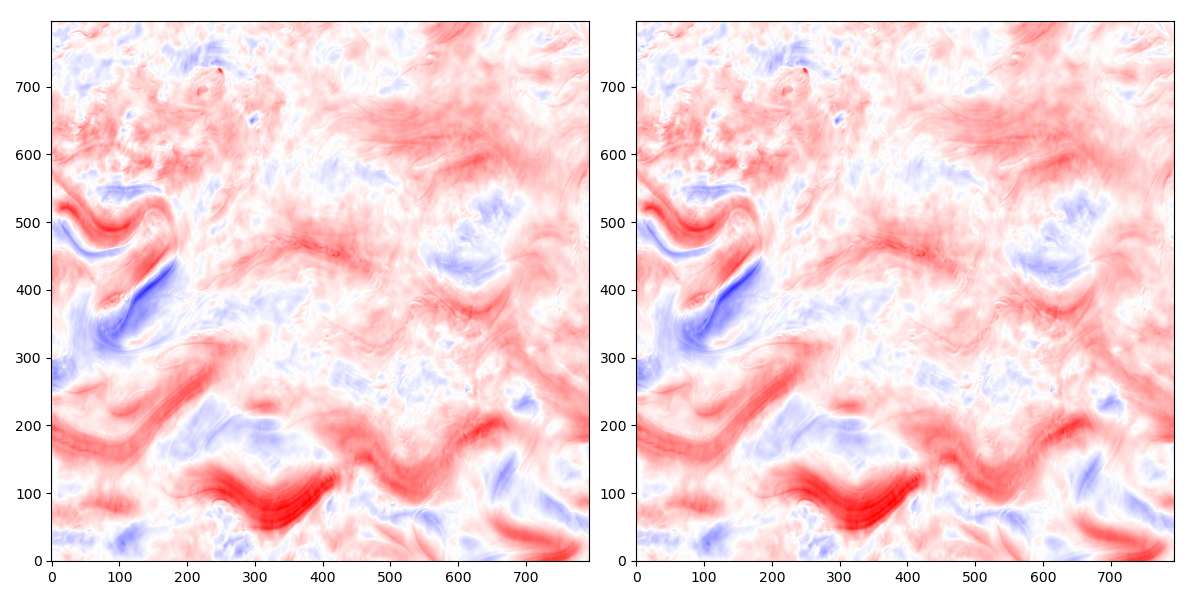

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='300px'), max=4), Output()), _do…

interactive(children=(IntSlider(value=0, description='a', layout=Layout(width='300px'), max=5), Output()), _do…

In [3]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/RelWithDebInfo')
sys.path.insert(0, 'D:/pascucci/ppt/2022/6_NASA/idx2/build/Source/Python/RelWithDebInfo')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import os
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import *
import concurrent.futures

path_prefix = 'J:/nasa/'
if not os.path.exists (path_prefix): 
  path_prefix = "W:/cedmav/hello/"

%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

vmin = -1
vmax = 1

## Set up color map

import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

# Some helper functions

def get_file_name(input_dir, dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(dataset, face):
  if dataset == 'llc4320':
    if (face < 2):
      return (0, 0, 4320, 12960)
    elif (face > 2):
      return (0, 0, 12960, 4320)
    return (0, 0, 4320, 4320)
  elif dataset == 'llc2160':
    if (face < 2):
      return (0, 0, 2160, 6480)
    elif (face > 2):
      return (0, 0, 6480, 2160)
    return (0, 0, 2160, 2160)

def query_data_single_thread(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
  array = i2p.DecodeExtent3f32(file, input_dir, e, downsampling, accuracy)
  #print(array.shape)
  return array
  
# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(input_dir, dataset, times_per_file, times_per_brick, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(dataset, face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(input_dir, dataset, field, face, depth, file_time_from, file_time_to)
    
  array = None
  if extent[2] < 16 or extent[3] < 16: # if too small, don't spawn threads
    e = (extent[0], extent[1], time_extent_from, extent[2], extent[3], times_per_brick)
    array = i2p.DecodeExtent3f32(file, input_dir, e, downsampling, accuracy)
  else:
    with concurrent.futures.ThreadPoolExecutor() as executor:
      f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
      f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
      f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
      f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
      a1 = f1.result()
      a2 = f2.result()
      a3 = f3.result()
      a4 = f4.result()
      shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
      array = np.empty(shape)

      array[:, :a1.shape[1], :a1.shape[2]] = a1
      array[:, :a2.shape[1], a1.shape[2]:] = a2
      array[:, a1.shape[1]:, :a3.shape[2]] = a3
      array[:, a1.shape[1]:, a3.shape[2]:] = a4
  
  return array

# Zoomed in visualization


input_dir = path_prefix + 'llc4320_64'
dataset = 'llc4320'
n = 4320
times_per_file = 64
times_per_brick = 64
face = 0
depth = 0
time = 0
accuracy = 0.1
downsampling = [0, 0, 0]

xbegin = 100
ybegin = 300
xdim   = 50
ydim   = 50

def to_face(f):
  return f+1 if f >= 2 else f

def query_region(down, accu):
  global xbegin, ybegin, depth
  extent = (1588, 4788, 794, 798)

  with concurrent.futures.ThreadPoolExecutor() as executor:
    min_face = 4
    max_face = 0
    a = [np.empty((1,1,1), float)] * 4
    for ff in range(0, 4):
      f = to_face(ff)
      m = max(extent[0], n*ff)
      M = min(extent[0]+extent[2], n*(ff+1))
      if m < M:
        e = (m-n*ff, extent[1], M-m, extent[3]) if f < 2 else (n*3-extent[1]-int(ydim*s[1]), m-n*ff, extent[3], M-m)   
        if f < 2:
          a[ff] = query_data_single_thread(input_dir, dataset, times_per_file, times_per_brick, 'u', f, depth, time, down, accu, e)  
        else:
          a[ff] = query_data_single_thread(input_dir, dataset, times_per_file, times_per_brick, 'v', f, depth, time, down, accu, e)  
        min_face = min(min_face, ff)
        max_face = max(max_face, ff)
    dt = a[min_face].shape[0]            
    b = [np.empty((1, 1, 1), float)] * (max_face+1-min_face)
    for face in range(min_face, max_face + 1):
      f = face - min_face
      if face < 2:
        b[f] = a[face]
      else:
        b[f] = np.empty((dt, a[face].shape[2], a[face].shape[1]))
        for tt in range(0, dt):
          b[f][tt, :, :] = np.rot90(a[face][tt, :, :])        
    return np.concatenate(b, 2)

array = query_region((0, 0, 0), 0)
#print(array.shape)

px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, (ax, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 6)
plot = ax.imshow(array[0, :, :], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)
#plt.colorbar(plot)

fig.tight_layout()
array2 = query_region((0, 0, 0), 0.001)
plot2 = ax2.imshow(array2[0, :, :], origin = 'lower', cmap = 'bwr', aspect = 'auto', vmin = vmin, vmax = vmax)

#plt.show()
time_block = 0
current_time = 0

def draw_region():
  plot2.set_data(array2[0, :,:])

pause = True

def onClick(event):
  global pause
  pause ^= True
  
fig.canvas.mpl_connect('button_press_event', onClick)

def change_resolution(d):  
  global downsampling, accuracy, array2
  downsampling = (d, d, 0)
  array2 = query_region(downsampling, accuracy)
  draw_region()

accuracy_choices = [0, 0.001, 0.01, 0.1, 1, 10]
  
def change_accuracy(a):
  global accuracy, downsamnpling, array2
  accuracy = accuracy_choices[a]
  array2 = query_region(downsampling, accuracy)
  draw_region()

def animate(t):
  global pause
  if pause:
    return
  plot.set_data(array[t//pow(2,downsampling[2]), :,:])
  plot2.set_data(array2[t//pow(2,downsampling[2]), :,:])
  return [plot2]

anim = FuncAnimation(fig, animate, frames=times_per_brick, interval=100, blit=True, repeat=True)
interact(change_resolution, d = widgets.IntSlider(min = 0, max = 4, step = 1, value = downsampling[0], layout = Layout(width = '300px')));
interact(change_accuracy, a = widgets.IntSlider(min = 0, max = len(accuracy_choices)-1, step = 1, value = 0, layout = Layout(width = '300px')));